# 相对强弱市场
*强者越强，弱者越弱*

## 目录
1. 什么是相对强弱？
2. 怎么计算相对强弱？
3. 如何用图形展示相对强弱？
4. 如何用相对强弱来编写策略？

## 什么是相对强弱？
一段时间内某股票和本行业的股票或整个市场的比较，即对该股票市场表现的计量。

## 怎么计算相对强弱？
RS = Stock/Index

MOM_RS = Momentum(RS)

MOM_MOM = Momentum(MOM_RS)

## 如何用图形展示相对强弱？

In [1]:
from jaqs_fxdayu.data import DataView
from jaqs_fxdayu.data import RemoteDataService
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

D:\Anaconda3\lib\importlib\__init__.py:126: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _bootstrap._gcd_import(name[level:], package, level)


Dataview loaded successfully.


In [2]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df
stock = change_index(dv.get_ts('close_adj').loc[20170105:])
hs300 = change_index(dv.data_benchmark.loc[20170105:])

In [3]:
RS = stock['600036.SH']/hs300.close
RS = RS.dropna()
print (RS.tail())

2017-12-25    0.033548
2017-12-26    0.033928
2017-12-27    0.033357
2017-12-28    0.032977
2017-12-29    0.033327
dtype: float64


In [4]:
#Momentum_RS
import talib as ta

MOM_RS = ta.ROCR100(RS.values, 20)
MOM_MOM = ta.ROCR100(MOM_RS, 20)
data_s = stock['600036.SH']
data1 = pd.Series(MOM_RS, index=RS.index)
data2 = pd.Series(MOM_MOM, index=RS.index)
data = pd.concat([data_s, RS, data1, data2], axis=1)
data.columns = ['close', 'RS', 'MOM_RS', 'MOM_MOM']
print (data.tail())

                 close        RS      MOM_RS    MOM_MOM
2017-12-25  135.587218  0.033548   98.229352  92.275070
2017-12-26  137.531452  0.033928  101.836699  95.703934
2017-12-27  133.133779  0.033357   98.818309  91.211470
2017-12-28  132.531992  0.032977   98.443699  91.925767
2017-12-29  134.337353  0.033327  100.609734  95.288634


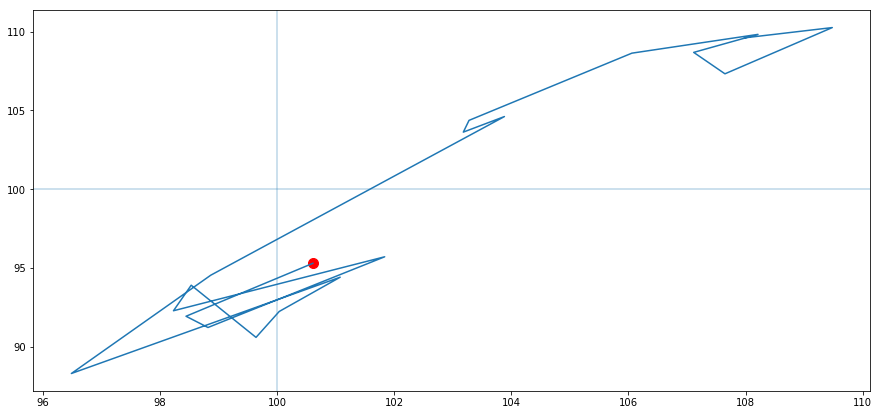

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(data.MOM_RS.tail(20).values, data.MOM_MOM.tail(20).values)
plt.axhline(100,alpha=0.3)
plt.axvline(100,alpha=0.3)
X=data['MOM_RS'].iloc[-1]
Y=data['MOM_MOM'].iloc[-1]
plt.scatter(X,Y,color='r', s=100)
plt.show()

## 如何用相对强弱来编写策略？
**买入时机：**

第一象限：（MOM_RS>100, MOM_MOM>100）

第四象限：（MOM_RS< 100, MOM_MOM >100）

**卖出时机**

第二象限：（MOM_RS > 100, MOM_MOM < 100）

第三象限：（MOM_RS< 100, MOM_MOM < 100）

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


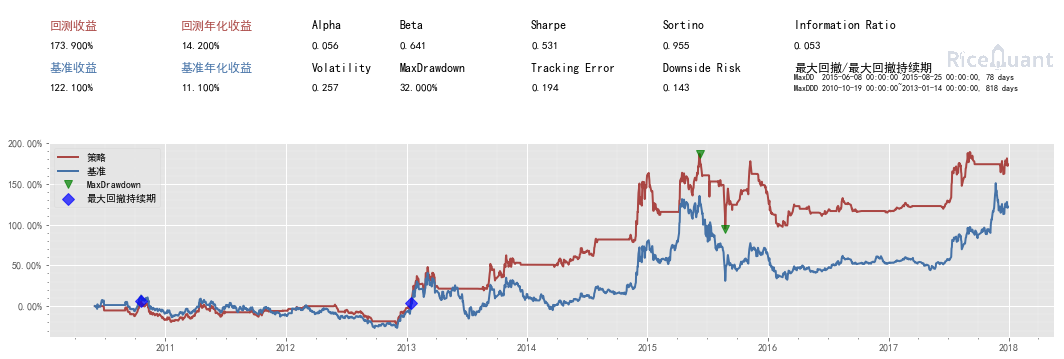

{'sys_analyser': {'benchmark_portfolio':                  cash  market_value  static_unit_net_value  total_value  \
  date                                                                      
  2010-06-01      8.100    999991.900                  1.000  1000000.000   
  2010-06-02      8.100    995945.690                  1.000   995953.790   
  2010-06-03      8.100    995367.660                  0.996   995375.760   
  2010-06-04      8.100    999991.900                  0.995  1000000.000   
  2010-06-07      8.100    977448.730                  1.000   977456.830   
  2010-06-08      8.100    965310.100                  0.977   965318.200   
  2010-06-09      8.100   1021379.010                  0.965  1021387.110   
  2010-06-10      8.100    989009.330                  1.021   989017.430   
  2010-06-11      8.100    991321.450                  0.989   991329.550   
  2010-06-17      8.100    991321.450                  0.991   991329.550   
  2010-06-18      8.100   1001147.960

In [6]:
#Relative_Strength

import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.index = "000300.XSHG"
    context.PERIOD = 50
    
def handle_bar(context, bar_dict):
    price = history_bars(context.s1, context.PERIOD*3, '1d', 'close')
    index = history_bars(context.index, context.PERIOD*3, '1d', 'close')
    
    if len(price)==len(index):
        RS = price/index
        MOM = talib.ROCR100(RS, context.PERIOD)
        if len(MOM)>context.PERIOD:
            MOM_MOM = talib.ROCR100(MOM, context.PERIOD)
            cur_position = context.portfolio.positions[context.s1].quantity
            shares = context.portfolio.cash/bar_dict[context.s1].close

            if (MOM_MOM[-1]<100) and (MOM_MOM[-2]>100):
                order_target_value(context.s1, 0)

            if (MOM_MOM[-1]>100) and (MOM_MOM[-2]<100) and (cur_position==0):
                order_shares(context.s1, shares)
        
config = {
  "base": {
    "start_date": "2010-06-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

## 作业
根据以上代码做出其他象限进场的策略